<a href="https://colab.research.google.com/github/arthurPignet/mva-generative-modeling-project/blob/main/ARDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto regressive diffusion models

This notebook aims to reproduce our experiment on the binarized MNIST dataset. We used the code released with the paper for the training part. However, we modified the code in order to have it working, especially for the dataset management, and the sampling, which was not working. 

We also of course changed the config file. Unfortunatly, we were not able to run the training for a long time, as we only have access to the free version of colab. Moreover our colabs were also extensively used in other courses, for practicals, and other projects. We thus trained the model as much as possible before being cut by Colab from GPU access. Moreover we were sometimes disconnected, or ran out of memory. All of this to explain that if you want to re-do our experimetn from scratch, you might need to re-lauch the training several times, as we did. We advice to re-load the model last checkpoint. 

We mounted the disk to our drive in order to keep the checkpoints even when being disconnect form the instance. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [6]:
# Get the source code.
!git clone https://github.com/arthurPignet/mva-generative-modeling-project.git
%cd mva-generative-modeling-project/
!git pull

fatal: destination path 'mva-generative-modeling-project' already exists and is not an empty directory.
/content/drive/My Drive/mva-generative-modeling-project
Already up to date.


In [7]:
# check for GPU. 
!nvidia-smi

Sun Apr 24 12:43:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Install the dependencies. 
!pip install jax
!pip install flax
!pip install clu

     |████████████████████████████████| 184 kB 4.8 MB/s 
     |████████████████████████████████| 140 kB 48.1 MB/s 
     |████████████████████████████████| 72 kB 607 kB/s 
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 462 kB 43.2 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=92745261b74c61ea91561d63dceaa247e8fc6637e373b9bfe1f44ebba59a7364
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections



# Training

For the training we use the code provided by the authors. If you want to re-run our experiment from scratch, change the `work_unit_dir`. We changed the config, with a smaller network and the dataset `binarized_mnist`. 

In [ ]:
!python -m autoregressive_diffusion.experiments.images.main -work_unit_dir=results/bin_mnist_2 --config autoregressive_diffusion/experiments/images/config_simple.py 

I0423 19:58:07.508756 139980702562176 xla_bridge.py:253] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
I0423 19:58:07.594098 139980702562176 xla_bridge.py:253] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
I0423 19:58:07.594364 139980702562176 main.py:48] JAX process: 0 / 1
I0423 19:58:07.594489 139980702562176 main.py:51] JAX local devices: [GpuDevice(id=0, process_index=0)]
I0423 19:58:07.594583 139980702562176 local.py:51] Created artifact work_unit_dir of type ArtifactType.DIRECTORY and value results/bin_mnist_2.
I0423 19:58:07.594687 139980702562176 train.py:371] Running with seed 0.
2022-04-23 19:58:08.241185: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2140] Execution of replica 0 failed: INTERNAL: CustomCall failed: jaxlib/cuda_prng_kernels.cc:30: operation cudaGetLastError() failed: out of memory
Traceback (most recent call last):
  File "/co

# Load the model and sample from it.

In order to get samples from the trained model, we had to modify the provided code, as it was not working. However, big part of it are taken from the basecode.

In [9]:
from autoregressive_diffusion.experiments.images.config_simple import get_config
from autoregressive_diffusion.experiments.images import checkpoint
from autoregressive_diffusion.experiments.images import custom_train_state
from autoregressive_diffusion.experiments.images import datasets
from autoregressive_diffusion.experiments.images.architectures import unet
from autoregressive_diffusion.model.autoregressive_diffusion import ao_arm
from autoregressive_diffusion.model.autoregressive_diffusion import bit_ao
from autoregressive_diffusion.experiments.images.train import model_setup
from autoregressive_diffusion.utils import util_fns

import optax
import jax
import jax.numpy as jnp

In [10]:
config = get_config()

In [11]:
config

architecture:
  attn_resolutions:
  - 8
  - 7
  - 4
  ch_mult:
  - 1
  dropout: 0.0
  n_channels: 32
  num_heads: 1
  num_res_blocks: 3
batch_size: 128
beta2: 0.999
ce_term: 0.001
clip_grad: 100.0
data_augmentation: false
dataset: binarized_mnist
detailed_eval_every: 1000
elbo_mode: uniform
learning_rate: 0.0001
model: ao_arm
momentum: 0.9
num_epochs: 1000
num_eval_passes: 4
num_mixtures: 30
num_samples: 16
output_distribution: softmax
save_every: 2
seed: 0
test_batch_size: 200
upscale_branch_factor: 4
upscale_direct_parametrization: false
upscale_mode: zero_least_significant

In [12]:
key = jax.random.PRNGKey(0)
data_rng, rng = jax.random.split(key)

In [13]:
train_ds, test_ds, shape, num_classes = datasets.get_dataset(config, data_rng)

# config.mask_shape = mask_shape
config.data_shape = shape
config.num_classes = num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/binarized_mnist/1.0.0.incompleteIUXY18/binarized_mnist-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/binarized_mnist/1.0.0.incompleteIUXY18/binarized_mnist-validation.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/binarized_mnist/1.0.0.incompleteIUXY18/binarized_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset binarized_mnist downloaded and prepared to /root/tensorflow_datasets/binarized_mnist/1.0.0. Subsequent calls will reuse this data.
train 50000


In [14]:
model, variables = model_setup(key, config)

In [15]:
model

ArbitraryOrderARM(config=architecture:
  attn_resolutions:
  - 8
  - 7
  - 4
  ch_mult:
  - 1
  dropout: 0.0
  n_channels: 32
  num_heads: 1
  num_res_blocks: 3
batch_size: 128
beta2: 0.999
ce_term: 0.001
clip_grad: 100.0
data_augmentation: false
data_shape: &id001 !!python/tuple
- 28
- 28
- 1
dataset: binarized_mnist
detailed_eval_every: 1000
elbo_mode: uniform
learning_rate: 0.0001
mask_shape: *id001
model: ao_arm
momentum: 0.9
num_classes: 2
num_epochs: 1000
num_eval_passes: 4
num_mixtures: 30
num_samples: 16
output_distribution: softmax
save_every: 2
seed: 0
test_batch_size: 200
upscale_branch_factor: 4
upscale_direct_parametrization: false
upscale_mode: zero_least_significant
, apply_fn=<bound method Module.apply of UNet(
    # attributes
    num_classes = 2
    ch = 32
    out_ch = 2
    ch_mult = [1]
    num_res_blocks = 3
    full_attn_resolutions = [8, 7, 4]
    num_heads = 1
    dropout = 0.0
    max_time = 784.0
)>, logprob_fn=<bound method SoftmaxCategorical.log_prob of Sof

In [16]:
# we are not going to use this optimizer but we need an optimizer object to create the state, and then load the last chekpoint in it.  
tx = optax.adam(
      config.learning_rate, b1=0.9, b2=config.beta2, eps=1e-08, eps_root=0.0)
state = custom_train_state.TrainState.create(
      params=variables['params'], tx=tx)

In [17]:
# load the last checkpoint 
work_dir= 'results/bin_mnist_2'
state, start_epoch = checkpoint.restore_from_path(work_dir, state)

In [18]:
params = state.ema_params

In [19]:
from autoregressive_diffusion.model.autoregressive_diffusion import ardm_utils

chain_out_size = 20 # we want to output only 20 intermediate images per sample. 
context  = None
per_device_batch_size =4 # we want to sample 4 images. 
print('Sampling from model, hope you are patient...') # <- this was actually in the code provided with the paper. 

rng, rng_perm = jax.random.split(rng)
sigmas = ardm_utils.get_batch_permutations(rng_perm, per_device_batch_size,
                                            model.num_steps)

x = jnp.full((per_device_batch_size, *model.config.data_shape),
                fill_value=model.absorbing_state,
                dtype=jnp.int32)


def next_sample_step(state, t):
    chain, x = state
    x = model.sample_step(
        jax.random.fold_in(rng, t), x,
        t, sigmas, params, context)

    # Compute the write index. Minimum is 0, maximum is chain_out_size - 1.
    write_index = (t * chain_out_size) // model.num_steps

    # May simply overwrite if write_index lands on the same index again, this
    # is desired behaviour and as a result the final index will also be the
    # complete sample.
    chain = jax.lax.dynamic_update_slice(
        chain, jnp.expand_dims(x, axis=0), (write_index,) + (0,) * x.ndim)
    return (chain, x), None
# Every step of the generative process.
ts = jnp.arange(model.num_steps)

# `chain` is an output buffer that will contain intermediate states.
chain = jnp.zeros(
    (chain_out_size, per_device_batch_size) + model.config.data_shape,
    dtype=x.dtype)
state, _ = jax.lax.scan(
    next_sample_step, init=(chain, x), xs=ts)
chain, _ = state

Sampling from model, hope you are patient...


In [20]:
import matplotlib.pyplot as plt

In [21]:
( model.num_steps//chain_out_size)

39

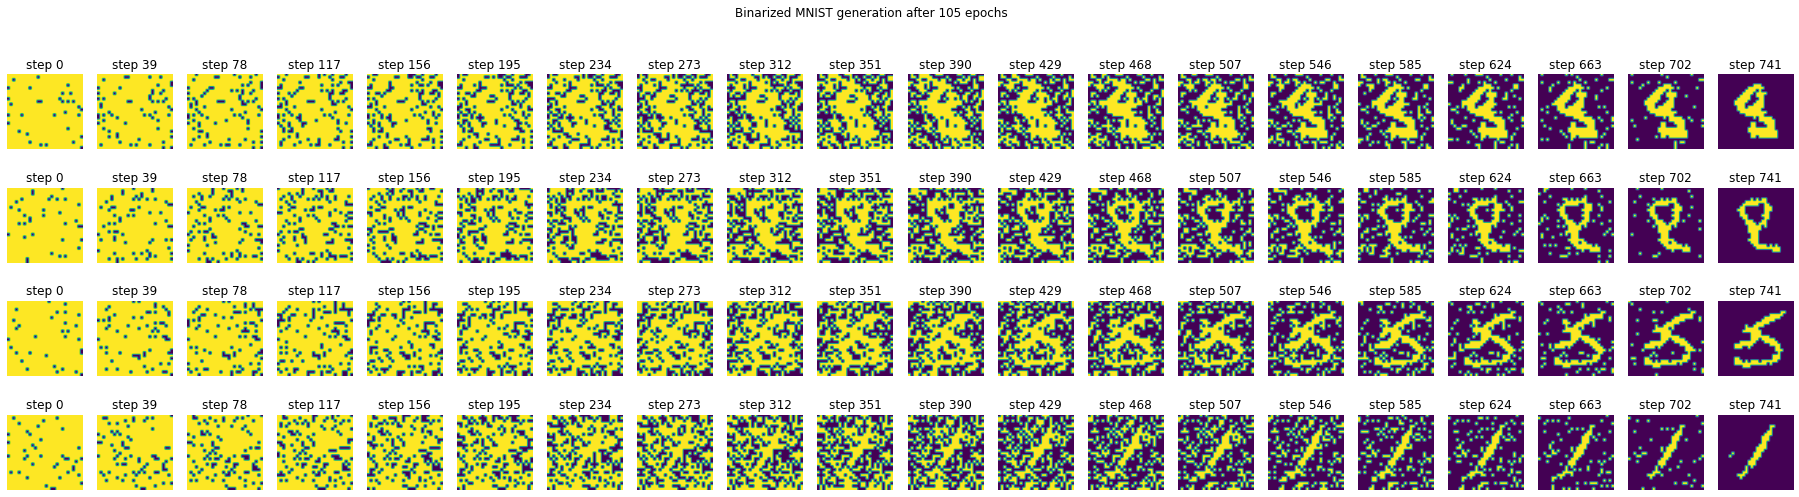

In [23]:
f, ax =plt.subplots(per_device_batch_size, chain_out_size, figsize=(32,8))
f.suptitle('Binarized MNIST generation after 105 epochs')
for i in range(per_device_batch_size):
  for j in range(chain_out_size):
    ax[i,j].imshow(chain[j,i,:,:,0])
    ax[i,j].axis('off')
    ax[i,j].set_title(f'step {(model.num_steps//chain_out_size)*j}')

In [ ]:
!git add .

In [ ]:
!git commit -m 'final checkpoint(105 epochs)'

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!git push

fatal: could not read Username for 'https://github.com': No such device or address
